In [22]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,train_test_split)
from sklearn.metrics import (accuracy_score, classification_report,
confusion_matrix, mean_absolute_error,roc_auc_score)
from sklearn.ensemble import (AdaBoostClassifier, RandomForestClassifier,RandomForestRegressor)
import re,random,sys,json,time,os,warnings,pickle,datetime,subprocess,requests,math
import pyforest,klib,missingno as msno
import numpy as np, pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
#import keras as kr,tensoflow as tf,cv2 as cv

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set(style='whitegrid', color_codes=True, font_scale=1.5,
        palette='hls', font='Arial', rc={'figure.figsize': (10, 8)})

In [23]:
# Read the data
data = pd.read_csv('../data/melb_data.csv')
data.head()


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.00,S,Biggin,3/12/2016,2.50,3067.00,2.00,1.00,1.00,202.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
1,Abbotsford,25 Bloomburg St,2,h,1035000.00,S,Biggin,4/02/2016,2.50,3067.00,2.00,1.00,0.00,156.00,79.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
2,Abbotsford,5 Charles St,3,h,1465000.00,SP,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,0.00,134.00,150.00,1900.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00
3,Abbotsford,40 Federation La,3,h,850000.00,PI,Biggin,4/03/2017,2.50,3067.00,3.00,2.00,1.00,94.00,NaN,NaN,Yarra,-37.80,145.00,Northern Metropolitan,4019.00
4,Abbotsford,55a Park St,4,h,1600000.00,VB,Nelson,4/06/2016,2.50,3067.00,3.00,1.00,2.00,120.00,142.00,2014.00,Yarra,-37.81,144.99,Northern Metropolitan,4019.00


In [24]:

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)


In [25]:
# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [26]:

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)

categorical_cols = X_train_full.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Suburb',
 'Address',
 'Type',
 'Method',
 'SellerG',
 'Date',
 'CouncilArea',
 'Regionname']

In [27]:
numerical_cols = X_train_full.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols

['Rooms',
 'Distance',
 'Postcode',
 'Bedroom2',
 'Bathroom',
 'Car',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude',
 'Propertycount']

In [28]:


# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [29]:
# X_valid

<AxesSubplot:>

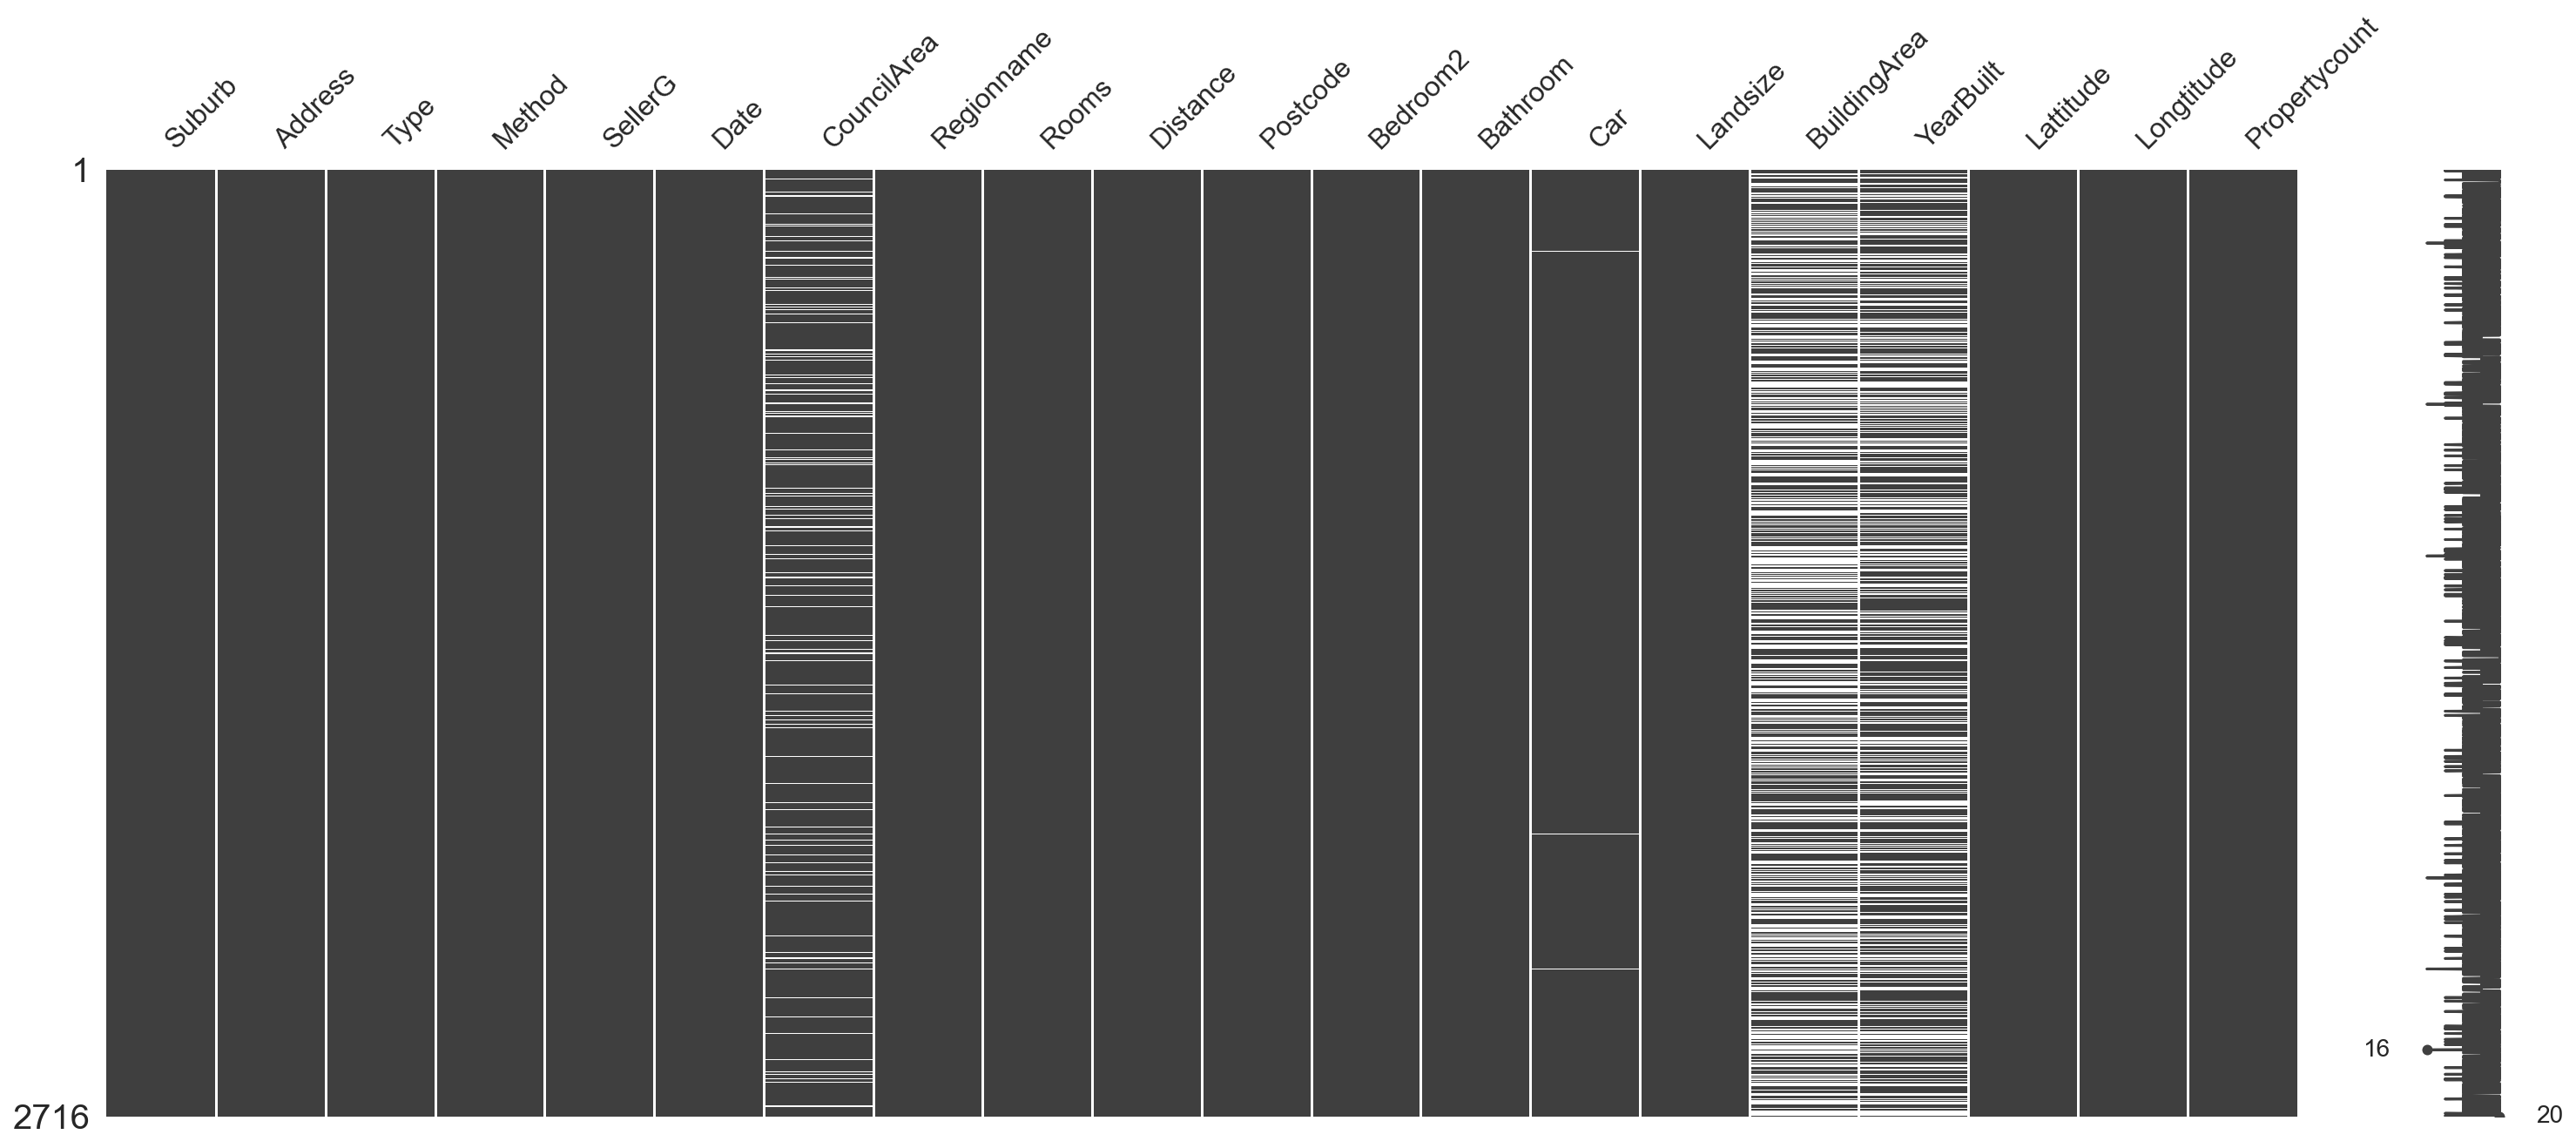

In [30]:
msno.matrix(X_valid)

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

In [32]:

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])